### Split Overlapping Pipelines

Buffers around two points create two circles. If the two circles overlap, we need to be able to split them to prevent overlapping samples. 

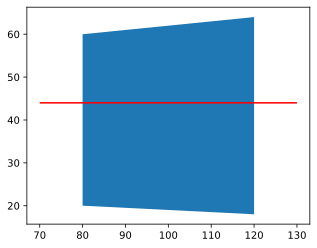

In [228]:
from shapely.geometry import LineString, MultiPolygon, Polygon, Point
from shapely.ops import polygonize, unary_union, linemerge, nearest_points
import matplotlib.pyplot as plt
import geopandas as gpd

# make a polygon that needs splitting
input_p = Polygon([[80, 20], [80, 60] ,[120, 64] , [120, 18]])

# add an intersecting line
input_l = LineString([[70, 44 ], [130, 44]])

fig, ax = plt.subplots()
gpd.GeoSeries(input_l).plot(ax=ax, color='red')
gpd.GeoSeries(input_p).plot(ax=ax);

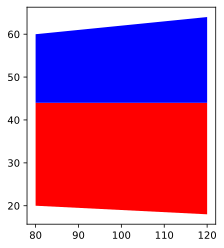

In [230]:
# union the exterior lines of the polygon with the dividing linestring
unioned = input_p.boundary.union(input_l)

# use polygonize geos operator and filter out polygons ouside of origin input polygon
keep_polys = [poly for poly in polygonize(unioned) if poly.representative_point().within(input_p)]
mm = MultiPolygon(keep_polys)

# Plot split polygons
fig, ax = plt.subplots()
gpd.GeoSeries(mm.geoms[0]).plot(ax=ax, color='red')
gpd.GeoSeries(mm.geoms[1]).plot(ax=ax, color='blue');

### Two Overlapping Buffer Circles

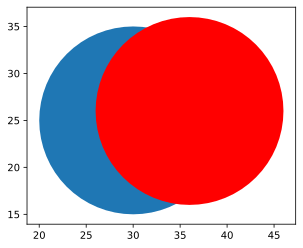

In [231]:
# Create points
p1 = Point(30, 25)
p2 = Point(36, 26)

# Create buffer circles
pb1= p1.buffer(10)
pb2 = p2.buffer(10)

# Plot Circles
fig, ax = plt.subplots()
gpd.GeoSeries(pb1).plot(ax=ax)
gpd.GeoSeries(pb2).plot(ax=ax, color='red');

<ipython-input-233-0064fc0b19ba>:27: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoSeries(Polygon(borders[1])).plot(ax=ax, color='green')
<ipython-input-233-0064fc0b19ba>:28: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  gpd.GeoSeries(Polygon(borders[2])).plot(ax=ax, color='red');


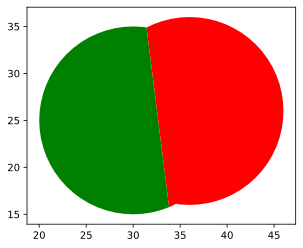

In [233]:
# Merge Polygons
un = unary_union([pb1, pb2])
sl = gpd.GeoSeries(un.boundary)

# Find point on edge
mr = sl.interpolate(sl.project(un.centroid))[0]
mr2 = sl.interpolate(sl.project(un.centroid))[0]

# Create half intersecting line 
c = Point([un.centroid.x,un.centroid.y])
line = LineString([mr, c])

# Extrapolate line to opposite edge
mr_coords = (mr.coords.xy[0][0], mr.coords.xy[1][0])
c_coords = (c.coords.xy[0][0], c.coords.xy[1][0])
dx = mr_coords[0] - c_coords[0]
dy = mr_coords[1] - c_coords[1]
np2 = Point(c.coords.xy[0][0] - dx, c.coords.xy[1][0]-dy)
fl = LineString([mr, np2])

# Split into two polygons
merged = linemerge([un.boundary, fl])
borders = unary_union(merged)

# Plot polygons
fig, ax = plt.subplots()
gpd.GeoSeries(Polygon(borders[1])).plot(ax=ax, color='green')
gpd.GeoSeries(Polygon(borders[2])).plot(ax=ax, color='red');

In [234]:
def split_circles(c1, c2):
    """
    Takes two overlapping circles (shapely polygons) 
    and returns two new polygons split down their center.
    :params: c1, c2 - Polygons - can be Shapely or GeoDataFrame rows 
    """
    un = unary_union([c1, c2])
    sl = gpd.GeoSeries(un.boundary)

    # Find point on edge
    mr = sl.interpolate(sl.project(un.centroid))[0]
    # create line
    c = Point([un.centroid.x,un.centroid.y])
    line = LineString([mr, c])
    # extrapolateline
    mr_coords = (mr.coords.xy[0][0], mr.coords.xy[1][0])
    c_coords = (c.coords.xy[0][0], c.coords.xy[1][0])
    dx = mr_coords[0] - c_coords[0]
    dy = mr_coords[1] - c_coords[1]
    np2 = Point(c.coords.xy[0][0] - dx, c.coords.xy[1][0]-dy)
    fl = LineString([mr, np2])
    # Split into two polygons
    merged = linemerge([un.boundary, fl])
    borders = unary_union(merged)
    
    # Return Polygons
    return [Polygon(borders[1]), Polygon(borders[2])]